In [40]:
import numpy as np
from scipy import signal
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import Audio
import ipywidgets as widgets

# Methods of Audio Analysis in Python

Intro

## Digital Signal Processing

...

### Sampling rate

Sound is produced by physical vibrations that cause fluctuations in air pressure (or another medium) around them. The frequencies of this vibration determine the pitch of the sound that is also transmitted into your ears. The pressure differentials reaching your eardrums cause them to vibrate at the same frequencies, which your brain interprets as sound. The vibration of the membrane of your eardrum is governed by the equation (up to scaling by volume)

$$y = \sin(2\pi f t),$$

where $f$ is the frequency and $t$ is time. We can visualise this as follows:

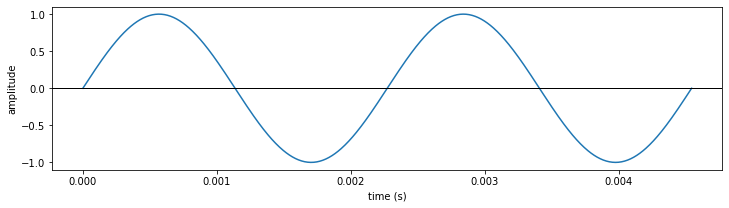

In [2]:
freq = 440
x = np.linspace(0, 2/freq, num=800)
A_4 = np.sin(2 * np.pi * freq * x)
plt.figure(figsize=(12, 3))
plt.plot(x, A_4)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.axhline(0, c='k', lw=1)
plt.show()

Here the amplitude of the oscillation depends on the volume of the sound. The above graph corresponds to a very short segment of the note A<sub>4</sub> (corresponding to the frequency 440 Hz). We can also listen to it with Python with the help of `IPython.display.Audio()`:

In [3]:
freq = 440
duration = 2
rate = 48000

# We use numpy's linspace() function to create an array of equally spaced values between 0 and `duration`
# The number of points to be generated is given by the num-argument.
t = np.linspace(0, duration, num=duration * rate)
y = np.sin(2 * np.pi * freq * t)

# The Audio() object of the IPython module is useful when working with audio analysis
# in Python. Its arguments are a list or ndarray (numpy array) of samples of the audio signal
# and the sample rate of the recording. Note that VSCode does not currently support audio playback.
Audio(y, rate=rate)

🔊 **Exercise:** Try adjusting the sample rate for the 440 Hz sine wave in the above cell. Does it affect what you hear? What happens if you set the sample rate very low? Why do you think that is?

In the above, the `rate` parameter is known as the **sampling rate**, which is a necessary evil when we are trying to represent a continuous signal, such as sound, in digital form. What happens is that in order to store the signal we take samples of it at (typically) equally spaced intervals and record the corresponding sequence of amplitudes in a file:

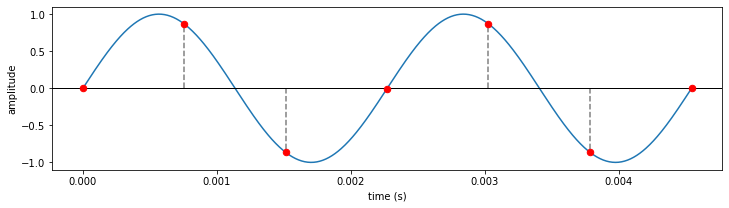

samples = [ 0.00e+00,  8.67e-01, -8.63e-01, -7.86e-03,  8.71e-01, -8.59e-01,
 -4.90e-16]


In [4]:
from math import ceil, floor
freq = 440
periods = 2
x = np.linspace(0, periods/freq, num=800)
y = np.sin(2 * np.pi * freq * x)
plt.figure(figsize=(12, 3))
samples = 7
plt.plot(x, y)
idx = np.linspace(0, len(x)-1, num=samples, endpoint=True, dtype=int)
plt.scatter(x[idx], y[idx], s=42, c='r', zorder=10)
plt.vlines(x[idx], 0, y[idx], ls='--', color='grey')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.axhline(0, c='k', lw=1)
plt.show()
print(f'samples = {np.array2string(y[idx], precision=2, separator=", ", sign=" ")}')

The sampling rate is then the number of samples we record per second. Then, in order to play back the digitised signal your computer attempts to reconstruct the original waveform based on the samples. Obviously, the more samples we take, the more accurate is the representation at the cost of consuming more memory. Below we visualise a naive linear interpolation scheme for reconstructing the original audio signal. Use the slider to experiment how the sampling rate affects the approximation.

> *In reality a more sophisticated interpolation scheme could be used, but that's out of scope for these lectures.*

In [5]:
freq = 440
periods = 2
x = np.linspace(0, periods/freq, num=800)
y = np.sin(2 * np.pi * freq * x)
def plot(n_samples):
    plt.figure(figsize=(12, 3))
    plt.plot(x, y, alpha=0.5)
    idx = np.linspace(0, len(x)-1, num=n_samples, endpoint=True, dtype=int)
    plt.plot(x[idx], y[idx], c='k')
    plt.scatter(x[idx], y[idx], s=42, c='r', zorder=10)
    plt.vlines(x[idx], 0, y[idx], ls='--', color='grey')
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.axhline(0, c='k', lw=1)
    plt.show()

widgets.interact(plot, n_samples=widgets.IntSlider(value=7, min=2, max=30));

interactive(children=(IntSlider(value=7, description='n_samples', max=30, min=2), Output()), _dom_classes=('wi…

### Nyquist frequency

In real life, sound is rarely so well-behaved. Even for simple signals the above exercise illustrates that it is necessary to store a lot of data if we want to have a faithful representation of the sound we are trying to analyse. In reality, the sounds we hear often comprise of a multitude of frequencies all mixed together.

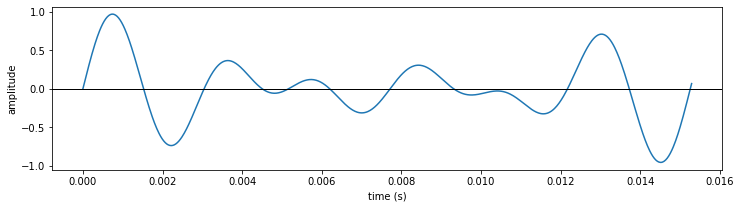

In [6]:
C_freqs = np.array([[261.626, 329.628, 391.995]])
x = np.linspace(0, 4/C_freqs[0][0], num=800)
C_major = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]
plt.figure(figsize=(12, 3))
plt.plot(x, C_major)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.axhline(0, c='k', lw=1)
plt.show()

The more complex the signal gets, the more samples we need to maintain the same level of accuracy for the reconstructed signal. In the above graph we've visualised the waveform for the C-major chord (which consists of three notes). You can listen to it below:
(add formula)

In [7]:
freqs = np.array([[261.626, 329.628, 391.995]])
duration = 2
rate = 48000
t = np.linspace(0, 2, num=duration * rate)
y = np.sum(np.sin(2 * np.pi * freqs.T * t), axis=0) / freqs.shape[1]
Audio(y, rate=rate)

🔊 **Exercise:** Try adjusting the sample rate for the C chord. What do you notice compared to the earlier example of the A<sub>4</sub> note?

You might notice that there is a huge discrepancy in the information content of the input signal versus what we would store on disk. To create the sound, all we did was specify three pieces of information (the frequencies), but we find that to store the data we need thousands of sample points per second! It turns out that relying on amplitude based representation is *fast* and *easy*, but also very wasteful. So why not just reconstruct the audio based on the frequencies?

In [8]:
C_freqs = np.array([[261.626, 329.628, 391.995]])
x = np.linspace(0, 4/C_freqs[0][0], num=800)
C_major = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]
y = C_major
def plot(samples):
    idx = np.linspace(0, len(x)-1, num=samples, endpoint=True, dtype=int)
    plt.figure(figsize=(12, 3))
    plt.plot(x[idx], y[idx], c='k')
    plt.scatter(x[idx], y[idx], s=42, c='r', zorder=10)
    plt.vlines(x[idx], 0, y[idx], ls='--', color='grey')
    plt.plot(x, y)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.axhline(0, c='k', lw=1)
    plt.show()

widgets.interact(plot, samples=widgets.IntSlider(value=14, min=2, max=30));

interactive(children=(IntSlider(value=14, description='samples', max=30, min=2), Output()), _dom_classes=('wid…

On the other hand, if we get unlucky, two different waves could produce the exact same quantisation:

In [9]:
freq = 440

def plot(n_samples, periods):
    # These are the multipliers to get aliased waves.
    # Note that m1, m2 == 1 (mod n_samples-1) and that
    # m1 & m2 don't depend on `periods` or `freq`
    m1 = 1 + (n_samples-1) * 1
    m2 = 1 + (n_samples-1) * 2
    
    x = np.linspace(0, periods/freq, num=10000)
    y1 = np.sin(2 * np.pi * freq * x)
    y2 = np.sin(2 * np.pi * (m1*freq) * x)
    y3 = np.sin(2 * np.pi * (m2*freq) * x)
    idx = np.linspace(0, len(x)-1, num=n_samples, endpoint=True, dtype=int)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
    ax1.plot(x, y1, alpha=0.5, label=f'{freq} Hz')

    ax1.plot(x[idx], y1[idx], c='k')
    ax1.scatter(x[idx], y1[idx], s=42, c='r', zorder=10)
    ax1.vlines(x[idx], 0, y1[idx], ls='--', color='grey')
    ax1.legend(loc='upper right')

    ax2.plot(x, y2, alpha=0.5, label=f'{m1*freq} Hz')
    ax2.plot(x[idx], y2[idx], c='k')
    ax2.scatter(x[idx], y2[idx], s=42, c='r', zorder=10)
    ax2.vlines(x[idx], 0, y2[idx], ls='--', color='grey')
    ax2.legend(loc='upper right')

    ax3.plot(x, y3, alpha=0.5, label=f'{m2*freq} Hz')
    ax3.plot(x[idx], y3[idx], c='k')
    ax3.scatter(x[idx], y3[idx], s=42, c='r', zorder=10)
    ax3.vlines(x[idx], 0, y3[idx], ls='--', color='grey')
    ax3.legend(loc='upper right')

    ax3.set_xlabel('time (s)')
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel('amplitude')
        ax.axhline(0, c='k', lw=1)
        #ax.set_xlim(0, 0.0035)
    plt.show()
    
widgets.interact(plot,
                 n_samples=widgets.IntSlider(value=7, min=2, max=20),
                 periods=widgets.IntSlider(value=2, min=1, max=5));

interactive(children=(IntSlider(value=7, description='n_samples', max=20, min=2), IntSlider(value=2, descripti…

> ☕️ **Aside (HARD):** How did we come up with the frequencies above? Note that 3080 / 440 = 7, 5720 / 440 = 13.

> *Hint #1: These multiples are independent of the base frequency (you can check by altering the code above).*

> *Hint #2: You have to consider the divisibility of the multipliers w.r.t. the number of samples.*
You can check the answer from the hidden code cell above.

This phenomenon, when two distinct signals produce the same sampled values, is called **aliasing**.
So how can we ensure that we avoid such situations? That is, how high should we set our sampling rate?

It turns out that the *sampling rate should be at least twice the highest frequency component* of the input signal.
That is, if we let $f_{s}$ denote the sampling frequency and $f_{max}$ the highest frequency component present in the input signal, then
we need

$$ f_{s} \geq 2 f_{max}.$$

This is called the **Nyquist criterion** and the minimal required sampling frequency (i.e. $2 f_{max}$) is called the **Nyquist rate**.

The main takeaway here is that if you wish to record audio for analysis purposes then in order to ensure a truthful representation
of the original signal you should keep the sampling rate above twice the highest frequency component that you might expect.
In practice common choices are e.g. 48 kHz, 96 kHz or 192 kHz (see [Sampling (Wikipedia)](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling)). In constrained situations you might have to survive with a lower resolution, but then it could be worth investigating how the lower sampling rate impacts the robustness of the analysis in that particular setting.

### Fourier Transform

We now know how the sampling rate affects the signal and how it is related to the frequency content resolution of the digitised signal, but how can we figure out the frequency content in the first place? Even trying to determine that the wave in the above example of the C-major chord is a sum of three different waves of distinct frequencies seems hopeless based just on the plot.

The answer to this problem is provided by the **Fourier transform**, which is a mathematical method for figuring out the periodic components of a function (by essentially comparing the function with waves of all possible frequencies). The matter is complicated slightly by the fact that we are dealing with a *sequence of samples* of a function rather than the actual continuous function itself. This means that we have to use an approximation called the **discrete Fourier transform** (DFT), which is usually implemented via a very efficient algorithm known as the **Fast Fourier Transform** (FFT). We won't go into the theoretical details in these lectures, but we can still understand what happens in practice.

So, suppose we have our input sequence, which in this instance is a set of samples of an audio waveform, and denote it by $\langle x_{n}\rangle = \{x_{0}, x_{1}, \ldots, x_{N-1}\}$ (i.e. $x_{0}$ is the first red dot above and we have $N$ sample points in our sequence in total). The FFT then transforms this sequence into a new sequence $\langle X_{k} \rangle = \{X_{0}, X_{1}, \ldots, X_{N-1}\}$ defined by
$$X_{k} = \sum_{n=0}^{N-1} x_{n}\left[\cos\bigl(\tfrac{2\pi}{N}kn\bigr)-i\sin\bigl(\tfrac{2\pi}{N}kn\bigr)\right].$$

The actual formula is not too important here, but what we care about is that $X_{k}$ *picks out the $k/N$ frequency component of $\langle x_{n}\rangle$*. In other words $X_{k}$ tells us how much (i.e. the *magnitude*) of the $k/N$ frequency is approximately present in the input signal. Actually $X_{k}$ is a complex number so in addition to magnitude it also contains phase information, but usually we are not too interested in this.

Enough of the theory, let's try it out in practice. In `numpy`, methods related to the DFT are implemented in the module `np.fft`.
In order to compute the FFT, we use the function `np.fft.rfft()`. The `r` in the function name signifies that we are computing the transformation of a *real-valued* sequence. This is always the case when the input is audio data.

In [ ]:
# We use the same sample data of a C major chord as in the above examples,
# except observed for a longer duration. This is so that the DFT
# approximation gets more accurate.

#x = np.linspace(0, duration, num=int(duration * sample_rate))
#y = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]

# We pass the sample sequence to np.fft.rfft(), it returns the transformed
# sequence of complex numbers describing the frequency content of y.
# We take absolute values in order to obtain the magnitude of each frequency

#y_abs = np.abs(np.fft.rfft(y))

# np.fft.rfftfreq() is a helper function that tells us what are the actual frequencies
# that the magnitudes stored in y_abs correspond to.

#freq = np.fft.rfftfreq(x.size, d=1./sample_rate)

In [145]:
def plot(sample_rate, duration):
    x = np.linspace(0, duration, num=int(duration * sample_rate))
    y = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]

    #y_abs = (np.abs(np.fft.rfft(y)) ** 2) / len(y)
    y_abs = np.abs(np.fft.rfft(y))

    freq = np.fft.rfftfreq(x.size, d=1./sample_rate)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 2]})
    ax1.plot(x, y)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('amplitude')
    ax1.set_ylim(-1., 1.)
    
    ax2.plot(freq, y_abs)
    for i, f in enumerate(C_freqs.ravel()):
        ax2.axvline(f, c='C6', ls='--', label='ground truth' if i == 0 else None)
    ax2.axvline(sample_rate/2, c='C1', label='Nyquist freq')
    ax2.axvline(2 * np.max(C_freqs), c='C2', label='Nyquist rate')
    ax2.scatter(sample_rate, -5, s=42, c='r', label='sampling rate', clip_on=False)
    #s.set_clip_on(False)
    ax2.set_ylim(-5, 200)
    ax2.set_xlim(0, 1050)
    ax2.set_xlabel('frequency (Hz)')
    ax2.legend(loc='upper right')
    fig.tight_layout()
    plt.show()

widgets.interact(plot,
                 sample_rate=widgets.IntSlider(value=900, min=50, max=1000),
                 duration=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.1));

interactive(children=(IntSlider(value=900, description='sample_rate', max=1000, min=50), FloatSlider(value=1.0…

Above we plot the input signal on the left and the magnitude of the DFT on the right (with blue). The pink vertical lines signify the true frequencies of C major, which are what we used to generate the sample data.

> 🔊 **Exercise**: Experiment with adjusting the sampling rate and duration of the input signal and notice how it affects the accuracy of the DFT.

We also visualise the sampling rate and the corresponding Nyquist frequncy as well as the Nyquist rate corresponding to this input date. You can see how lowering the sampling rate impacts our ability to detect the higher frequencies.

It's crucial to remember that we are performing implicit approximations at many steps of the process in going from the original audio signal to the sampled sequence and eventually to the resulting DFT. Hence the results *will not be exact*, as we can see above, and information leaks into nearby frequency bins.

---
### Windowing

Given an audio signal, we now know how to get a summary of its frequency content over the whole duration. This is already highly useful and many problems can be solved just by computing the DFT and looking at the distribution of the resulting frequencies in order to e.g. classify different audio clips.
However, this is a coarse summary statistic of the input audio and as the length of the clip increases its usefulness goes down (or rather the information content does -- think about computing averages of features over a large data set). In order to overcome this problem we apply a very simple trick: **windowing**.

In essence, all we do is split the input signal into pieces (which can be overlapping or disjoint) and compute the DFT of each piece separately. In practice, we obtain better results if we weigh the sample points towards the edges of each clip a bit less than the ones in the middle. This weighting is described by a **window function**.

There's a whole assortment of window functions available via SciPy's signal processing module `scipy.signal`, see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html) for a full list. Let's visualise a few of these below.
We use `scipy.signal.get_window()` to get the window data.

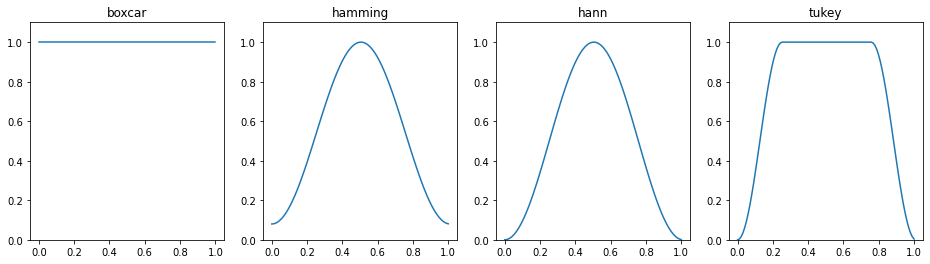

In [27]:
windows = ['boxcar', 'hamming', 'hann', 'tukey']

ncols = len(windows)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*4, 4))
for ax, wdw in zip(axs.flat, windows):
    N = 100
    x = np.linspace(0, 1, N)
    w = signal.get_window(wdw, N)
    ax.plot(x, w)
    ax.set_title(wdw)
    ax.set_ylim(0, 1.1)
plt.show()

Above on the left is the naive flat window, where each sample is weighted equally by 1. The following Hamming, Hann and Tukey windows are common choices and have been observed to perform well in many domains. We'll see another option in the next section. In general, there is no universal answer for which window type is best and you have to experiment with it yourself. On the other hand, the standard choices are usually OK and worrying about it further is unlikely to have much impact on your analysis.

Now, in order to perform the actual windowing we also need to determine how many sample points to include in each window. This is called the **window length**, which, together with **window overlap**, tells us what we need to split the signal.

In [96]:
C_freqs = np.array([[261.626, 329.628, 391.995]])
x = np.linspace(0, 4/C_freqs[0][0], num=800)
C_major = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]
y = C_major
n_samples = 75

window = 'hamming'
window_len = 9
window_overlap = 3

def plot(window, window_len, window_overlap):
    idx = np.linspace(0, len(x)-1, num=n_samples, endpoint=True, dtype=int)
    sample_x = x[idx]
    sample_y = y[idx]

    n_windows = len(sample_x) // (window_len - window_overlap) - 1
    window_data = []

    fig, axs = plt.subplots(figsize=(20, 3), ncols=5, gridspec_kw={'width_ratios': [4,1,1,1,1]})
    ax1 = axs[0]
    ax1.scatter(sample_x, sample_y, s=32, c='grey', zorder=10, alpha=0.8)
    #plt.vlines(x[idx], 0, y[idx], ls='--', color='grey')
    ax1.plot(x, y)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('amplitude')
    for i in range(n_windows):
        start = i * (window_len - window_overlap)
        end = start + window_len
        x_lb, x_ub = sample_x[start], sample_x[end]
        # for better window visualisation
        xx = np.linspace(x_lb, x_ub, 100)
        w_vis = signal.get_window(window, 100)
        ax1.plot(xx, w_vis, c='orange')
        # the real window
        w = signal.get_window(window, window_len)
        window_data.append(w * sample_y[start:end])
    #    ax.vlines(sample_x[start:end], sample_y[start:end], w, ls='--', color='grey', alpha=0.1)
    ax1.set_title('Input signal and windows')

    for i, ax in enumerate(axs.flat[1:]):
        start = i * (window_len - window_overlap)
        end = start + window_len
        xx = np.arange(window_len)
        ax.scatter(xx, sample_y[start:end], c='grey', s=64, label='original')
        ax.scatter(xx, window_data[i], c='C1', marker='v', s=24, alpha=0.75, label='weighted')
        ax.set_title(f'Data for window {i}')
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlabel('n')
        if i == 0:
            ax.legend(loc='lower left')

    for ax in axs:
        ax.axhline(0, c='k', lw=1)
    plt.show()

    widgets.RadioButtons(
    options=['pepperoni', 'pineapple', 'anchovies'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Pizza topping:',
    disabled=False
)

widgets.interact(plot,
                 window=widgets.RadioButtons(options=['boxcar', 'hann', 'hamming', 'tukey'],
                                            description='Window function',
                                            value='hann'),
                 window_len=widgets.IntSlider(value=9, min=9, max=15),
                 window_overlap=widgets.IntSlider(value=3, min=0, max=8));

interactive(children=(RadioButtons(description='Window function', index=1, options=('boxcar', 'hann', 'hamming…

Here we show the true signal as the blue curve on the left and the sampled points in grey. On the same axis we plot the window weights (which are also on scale 0 to 1) as orange curves. For each window, the sample points that fall inside it get weighted according to the value of the orange curve at that x-coordinate. In the plots on the right we visualise the resulting weighted data as orange triangles for the first few windows. For comparison, the original unweighted data is also display in grey.

---
### Spectrograms

We finally get to the most indispensable tool in audio analysis: the **spectrogram**. This is what we get when we combine windowing and DFT. We start by splitting the audio signal into smaller segments according to our desired window specifications, then for each segment we apply the DFT in order to get its frequency content. The resulting data can be organised into a matrix so that each
row corresponds to a specific frequency and columns to windows. The value of the $(i, j)$ cell is then the magnitude of the $i$-th frequency in the $j$-th window. This is easier to grasp if we visualise it as a heatmap.


In [151]:
duration = 10
SEED = 42

def plot(sample_rate, window, window_len, window_overlap_ratio):
    window_overlap = int(window_overlap_ratio * window_len)
    x = np.linspace(0, duration, num=int(duration * sample_rate))
    y = np.sum(np.sin(2 * np.pi * C_freqs.T * x), axis=0) / C_freqs.shape[1]
    rng = np.random.default_rng(SEED)
    y = np.clip(rng.normal(size=len(y)) + y, -1, 1)

    f, t, Sxx = signal.spectrogram(y, sample_rate, window=window, nperseg=window_len,
                                   noverlap=window_overlap, mode='magnitude')

    fig, ax = plt.subplots(figsize=(10, 4))
    p = ax.pcolormesh(t, f, Sxx, cmap='magma', shading='auto',
                     vmin=0, vmax=0.03)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(p)
    plt.show()

widgets.interact(plot,
                 sample_rate=widgets.Dropdown(options=[28000, 41000, 96000]),
                 window=widgets.RadioButtons(options=['boxcar', 'hann', 'hamming', 'tukey'],
                                            description='Window function',
                                            value='hann'),
                 window_len=widgets.IntSlider(value=2048, min=512, max=4096),
                 window_overlap_ratio=widgets.FloatSlider(value=0.25, min=0, max=0.9));

interactive(children=(Dropdown(description='sample_rate', options=(28000, 41000, 96000), value=28000), RadioBu…

Above we plot the spectrogram for the same signal of the C major as before, except this time we add some random noise to it to make the example a bit more interesting. We've also extended the signal to 10 seconds. The window overlap parameter is presented as a fraction of the window length. According to our earlier discussion, the intensity of the colour of each pixel in the spectrogram signifies how much of that particular frequency is present in the signal at given time (or more precisely in the corresponding window of the original sampled signal). Hence, we should expect to see three straight lines at the C major frequencies (roughly: 262 Hz, 330 Hz, 392 Hz) on top of the darker noisy background.

> 🔊 **Exercise**: Experiment with various FFT parameters. Try increasing the sampling rate. Why does this seem to make things worse sometimes? How and why is this related to the window length? Think about how the window length affects the frequency resolution (hint: recall the Nyquist frequency), i.e. how sharp the bright lines appear.

> ⚠️ **Note**: For real-world signals, it is usually desirable to transform the spectrogram to the **decibel scale**. For appropriately scaled signals this amounts to some constant multiple of the logarithm of the spectrogram. This is to approximate how humans perceive sound in that a doubling of the power of some frequency component results in a linear increase of roughly 3 dB for that frequency. You can also use `librosa.amplitude_to_db()`, [(docs)](https://librosa.org/doc/latest/generated/librosa.amplitude_to_db.html), to do the conversion.

> 🔊 **Exercise**: As a final exercise, try to apply the methods & code from this notebook to some real-world audio data instead of a synthetic signal. You can use `scipy.io.wavfile.read()`, [(docs)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html), to read in a wav file to a numpy array. Note that wavs come in many different formats, in particular, the values can be either floats in [-1, 1) or ints of a given bit depth. If you want to be consistent in your analysis, you should scale all your files to the same range. One good program to help with investigating and converting audio files is [SoX](https://sox.sourceforge.net).

## Where next?

Most audio analysis happens based on the spectrogram (i.e. in the **spectral domain**). There are many useful features you might want to compute based on it. For example, computing the overall **energy** of the signal is easy (think about why it's difficult to estimate it based on the raw signal, i.e. in the **time domain**), or you might be interested around which frequency most of that energy concentrates. These are all called **spectral features** and you can find links to various examples in the further reading section.

We leave experimentation with such features to the reader and instead dive deeper into the theory of an important characteristic of sound (or waves or oscillating forces in general) which is **harmonic frequencies** and **resonance**. This is a crucial component if we want to analyse e.g. human speech (how to tell vowels apart) or detect faults in machinery (how does a failing gearbox sound).

See you in part 2!


## Summary

In this lesson we learnt how sound from the real-world is translated into digital format via a **sampling process**. This necessarily results in a loss of information, but we can minimise its effect by understanding the concepts of **Nyquist frequency** and **Nyquist rate**. We understand that sound is a very complex signal and thus it requires extremely fine-grained data (sampled at a rate of tens of thousands of samples per second). The resulting sequence is tricky to analyse directly and hence we employ a **discrete Fourier transform** in order to separate the different frequency components of the sequence. For longer audio files it is useful to split it into (possibly overlapping) segments where the values inside each segment are weighted according to a **window function**. We can then perform the DFT on each of these segments separately to obtain a **spectrogram**, which shows how the strength of each frequency changes over time. The spectrogram is the most fundamental building block of audio analysis and is usually the first thing to investigate when performing exploratory analysis of sound.

## Further reading

- .